In [1]:
import sys
sys.path.append(r'../')
import numpy as np
from scipy import signal
import mat73
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Loss
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

2022-08-18 14:48:32.284946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-18 14:48:32.284966: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
class Database:
    def __init__(self):
        data_set_no = 0
        data_dict = mat73.loadmat('NoStim_Data.mat')
        data  = data_dict['NoStim_Data']

        deltaFOverF_bc = data['deltaFOverF_bc'][data_set_no]
        derivatives = data['derivs'][data_set_no]
        NeuronNames = data['NeuronNames'][data_set_no]
        fps = data['fps'][data_set_no]
        States = data['States'][data_set_no]


        self.states = np.sum([n*States[s] for n, s in enumerate(States)], axis = 0).astype(int) # making a single states array in which each number corresponds to a behaviour
        self.state_names = [*States.keys()]
        self.neuron_traces = np.array(deltaFOverF_bc).T
        self.derivative_traces = derivatives['traces'].T
        self.neuron_names = np.array(NeuronNames, dtype=object)
        self.fps = fps

def r2_single(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
    return 1 - mse(y_pred, y_true)/tf.math.reduce_variance(y_true)

def r2(Y_true, Y_pred):
    r2_list=[]
    for i in range(Y_true.shape[-1]):
        R2 = r2_single(Y_true[:,i], Y_pred[:,i])
        r2_list.append(R2)
    r2_list = tf.stack(r2_list)
    return tf.math.reduce_mean(r2_list)

def bandpass(traces, f_l, f_h, sampling_freq):
    cut_off_h = f_h*sampling_freq/2 ## in units of sampling_freq/2
    cut_off_l= f_l*sampling_freq/2 ## in units of sampling_freq/2

    sos = signal.butter(4, [cut_off_l, cut_off_h], 'bandpass', fs=sampling_freq, output='sos')
    ### filtering the traces forward and backwards
    filtered = signal.sosfilt(sos, traces)
    filtered = np.flip(filtered, axis=1)
    filtered = signal.sosfilt(sos, filtered)
    filtered = np.flip(filtered, axis=1)
    return filtered

def hits_at_rank(rank, Y_test, Y_pred):
    nbrs = NearestNeighbors(n_neighbors=rank, algorithm='ball_tree').fit(Y_test)
    distances, indices = nbrs.kneighbors(Y_test)
    return np.mean(np.linalg.norm(Y_pred - Y_test, axis=1) < distances[:,-1])

In [3]:
data = Database()
X = data.neuron_traces.T
B = data.states

## Preprocessing the data

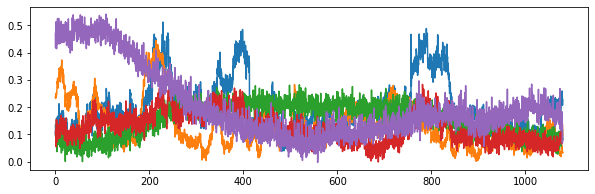

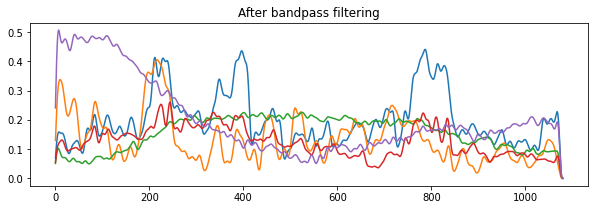

In [4]:
time = 1/data.fps*np.arange(0,X.shape[0])
filtered = bandpass(X.T, f_l=1e-10, f_h=0.05, sampling_freq=data.fps).T

nn = np.arange(80,85)
plt.figure(figsize = [10,3])
plt.plot(time, X[:,nn])
plt.figure(figsize = [10,3])
plt.plot(time, filtered[:,nn])
plt.title('After bandpass filtering')

plt.show()

In [5]:
X = filtered

### Preparing the data  

In [6]:
# Preparing the data (Method new)
win = 1
win += 1
gap = 1
X_win = np.zeros((X.shape[0]-win-gap, win, X.shape[1]))
#X_diff = np.zeros((X.shape[0]-win-gap, X.shape[1]))
#X_t = np.zeros((X.shape[0]-win-gap, X.shape[1]))
for i, _ in enumerate(X_win):
    X_win[i] = X[i:i+win]
    #X_diff[i] = X[i+win+gap-1] - X[i+win-1]
    #X_t[i] = X[i+win-1]

Xwin0, Xwin1 = X_win[:,:-1,:], X_win[:,1:,:]
B_1 = B[1:]
X_paired = np.array([Xwin0, Xwin1])
X_paired = np.transpose(X_paired, axes=(1,0,2,3))

# Train test split 
kf = KFold(n_splits=7)
for i, (train_index, test_index) in enumerate(kf.split(X_win)):
    if i==4: 
        # Train test split based on a fold
        X_train, X_test = X_paired[train_index], X_paired[test_index]
        B_train_1, B_test_1 = B_1[train_index], B_1[test_index]        
        #Xt_train, Xt_test = X_t[train_index], X_t[test_index]
        
        # Creating datasets for tf
        #batch_size = 100
        #train_dataset = tf.data.Dataset.from_tensor_slices((X_train, B_train_1))
        #train_dataset = train_dataset.batch(batch_size)
        
        #test_dataset = tf.data.Dataset.from_tensor_slices((X_test, B_test_1))
        #test_dataset = test_dataset.batch(batch_size)

        # Scaling the output
        #Xdmax = (np.abs(Xdiff_train)).max() # Parameter for scaling

        #Xdiff_train = Xdiff_train / Xdmax
        #Xdiff_test = Xdiff_test / Xdmax

    ####        ####        
    ####  Model ####
    ####        ####
    '''
    ### Inverse transform for evaluation
    Xdiff_pred = Xdiff_pred*Xdmax 
    Xdiff_test = Xdiff_test*Xdmax

    Xt1_pred = Xt_test + Xdiff_pred
    Xt1_test = Xt_test + Xdiff_test

    mse = tf.keras.losses.MeanSquaredError()
    print('Baseline error', mse(Xt1_test, Xt_test).numpy().round(5), 'Mean square error:', mse(Xt1_test, Xt1_pred).numpy().round(5))
    baseline_list.append(mse(Xt1_test, Xt_test).numpy())
    mse_list.append(mse(Xt1_test, Xt1_pred).numpy())
    '''

In [7]:
X_train = X_train[:,0,:,:]
X_test = X_test[:,0,:,:]

In [8]:
X_train.shape

(2686, 1, 109)

### Testing

mean vector of Y:  [4.10501764 3.09810743]
cov mtx of Y 
 [[ 1.69334336 -0.70884273]
 [-0.70884273  3.12095584]]


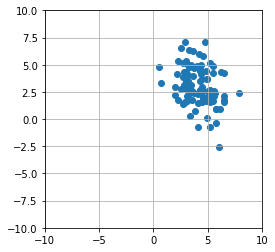

In [183]:
abatch1 = np.random.multivariate_normal(mean=np.array([4,5]), cov= [[2,-1],[-1,3]], size=100)
abatch2 = np.random.multivariate_normal(mean=np.array([4,3]), cov= [[2,-1],[-1,3]], size=100)
plt.scatter(abatch2[:,0], abatch2[:,1])
plt.axis('square')
plt.axis([-10,10,-10,10])
plt.grid(True)
print('mean vector of Y: ', np.mean(abatch2, axis=0))
print('cov mtx of Y \n', np.cov(abatch2.T))

mean vector of Y:  [-3.3378601e-08 -2.9206277e-08]
cov mtx of Y 
 [[ 1.00949903 -0.311314  ]
 [-0.311314    1.00977435]]


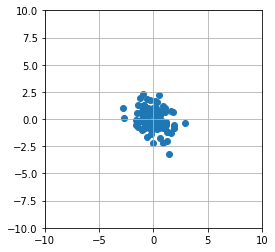

In [188]:
normlayer = layers.BatchNormalization()
normed = normlayer(abatch2,training=True).numpy()

plt.scatter(normed[:,0], normed[:,1])
plt.axis('square')
plt.axis([-10,10,-10,10])
plt.grid(True)
print('mean vector of Y: ', np.mean(normed, axis=0))
print('cov mtx of Y \n', np.cov(normed.T))

In [240]:
class scalarmult(layers.Layer):

    def __init__(self, scalar):
        super(scalarmult, self).__init__()
        # Create a non-trainable weight.
        self.scalar = scalar#tf.Variable(initial_value=scalar,trainable=False)

    def call(self, inputs):
        return tf.math.scalar_mul(self.scalar,inputs)

class Scaling(layers.Layer):

    def __init__(self, scalar):
        super(scalarmult, self).__init__()
        # Create a non-trainable weight.
        self.scalar = scalar#tf.Variable(initial_value=scalar,trainable=False)

    def call(self, inputs):
        return tf.math.scalar_mul(self.scalar,inputs)
    
scalarmult(14.2)(tf.Variable([0,1,5.,3]))


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0. , 14.2, 71. , 42.6], dtype=float32)>

Comparing last element of each window: true and predicted
Mean square error: 0.00458


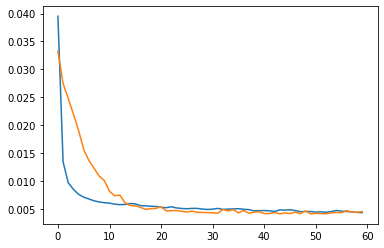

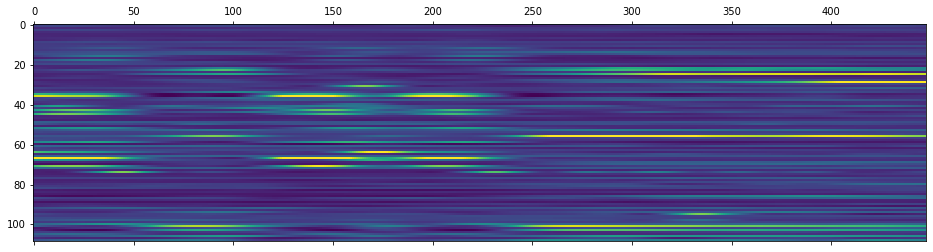

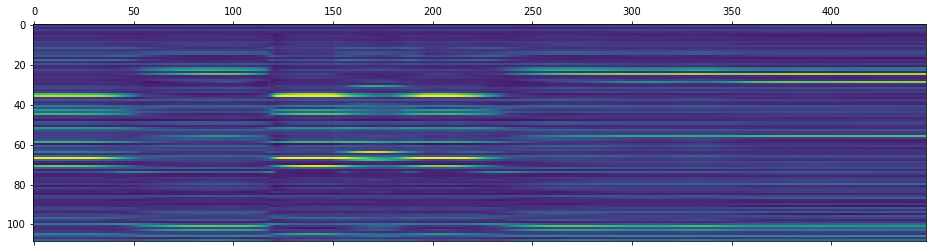

In [256]:
%matplotlib inline
# Defining the model
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
        #layers.Conv1D(filters=100,
        #                       kernel_size=(3,),
        #                       activation='relu', input_shape = (win,100,)),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(20, activation='relu'),
        layers.Dense(latent_dim, activation='relu'),
        #scalarmult()
    ])
    self.normlayer = tf.keras.Sequential([
        layers.BatchNormalization()
    ])
    
    self.decoder = tf.keras.Sequential([
        layers.Dense(latent_dim, activation='relu'),
        layers.Dense(20, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(100, activation='linear'),
        layers.Dense(X_train.shape[-1]*X_train.shape[-2], activation='linear'),
        layers.Reshape((X_train[0,:,:]).shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    normed = self.normlayer(encoded)
    decoded = self.decoder(normed)
    return decoded

autoencoder = Autoencoder(latent_dim = 3)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

autoencoder.compile(optimizer=opt,
              loss='mse',
              metrics=['mse'])

history = autoencoder.fit(X_train,
                      X_train,
                      epochs=60,
                      batch_size=100,
                      validation_data=(X_test, X_test),
                      verbose=0
                      )

# Summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

X_pred = autoencoder(X_test).numpy()
print('Comparing last element of each window: true and predicted')
plt.matshow(X_test[:,-1,:].T, vmin=0, vmax=1)
plt.matshow(X_pred[:,-1,:].T, vmin=0, vmax=1)

mse = tf.keras.losses.MeanSquaredError()
print('Mean square error:', mse(X_test, X_pred).numpy().round(5))

#### Plotting $Y$ dynamics


In [257]:
### Dynamics in the (learned) Y space
%matplotlib inline
Y = autoencoder.encoder(X_train).numpy()
print('mean vector of Y: ', np.mean(Y, axis=0))
print('cov mtx of Y \n', np.cov(Y.T))

Y_normed = autoencoder.normlayer(Y).numpy()
print('mean vector of Y_normed: ', np.mean(Y_normed, axis=0))
print('cov mtx of Y_normed \n', np.cov(Y_normed.T))

mean vector of Y:  [0.33131176 0.5911778  0.        ]
cov mtx of Y 
 [[0.03226378 0.01182476 0.        ]
 [0.01182476 0.08243717 0.        ]
 [0.         0.         0.        ]]
mean vector of Y_normed:  [-0.14627522  0.08828242 -0.14288329]
cov mtx of Y_normed 
 [[0.73739875 0.20264262 0.        ]
 [0.20264262 1.05928571 0.        ]
 [0.         0.         0.        ]]


(0.0, 2686.0, -0.5, 0.5)

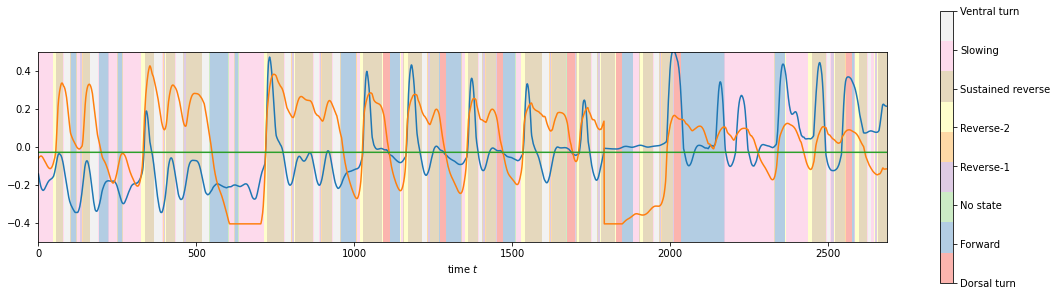

In [258]:
%matplotlib inline
plt.figure(figsize=(19,5))
plt.imshow([B],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y_normed/5)
plt.xlabel("time $t$")

plt.axis([0,Y_train.shape[0],-0.5,0.5])

In [259]:
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.animation as animation

def plot_phase_space(pca_neurons, states):
    if pca_neurons.shape[1]==3:
        fig = plt.figure(figsize=(8,8))
        ax = plt.axes(projection='3d')
        X = pca_neurons.T
        points = np.array(X).T.reshape(-1, 1, 3)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        colors = [*mcolors.TABLEAU_COLORS.keys()][:8] ###
        #cmap = cm.get_cmap('Pastel1')
        #colors = cmap(np.arange(8))
        for segment, state in zip(segments, states[:-1]):
            p = ax.plot3D(segment.T[0], segment.T[1], segment.T[2], color=colors[state] )
        # Create legend
        state_names = ['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']
        legend_elements = [Line2D([0], [0], color=c, lw=4, label=state) for c, state in zip(colors, state_names)]
        ax.legend(handles=legend_elements)
        plt.show()
    elif pca_neurons.shape[1]==2:
        fig = plt.figure(figsize=(8,8))
        ax = plt.axes()
        X = pca_neurons.T
        points = np.array(X).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        colors = [*mcolors.TABLEAU_COLORS.keys()][:8]
        #cmap = cm.get_cmap('Pastel1')
        #colors = cmap(np.arange(8))
        for segment, state in zip(segments, states[:-1]):
            p = ax.plot(segment.T[0], segment.T[1], color=colors[state])
        # Create legend
        state_names = ['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']
        legend_elements = [Line2D([0], [0], color=c, lw=4, label=state) for c, state in zip(colors, state_names)]
        ax.legend(handles=legend_elements)
    else:
        print("Error: Dimension of input array is neither 2 or 3")

<IPython.core.display.Javascript object>


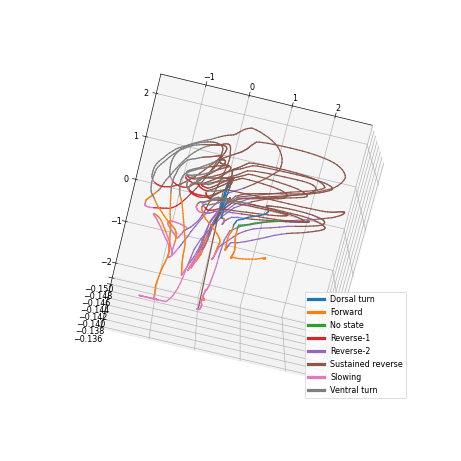

In [260]:
%matplotlib notebook
plot_phase_space(Y_normed, B_train_1)

<IPython.core.display.Javascript object>


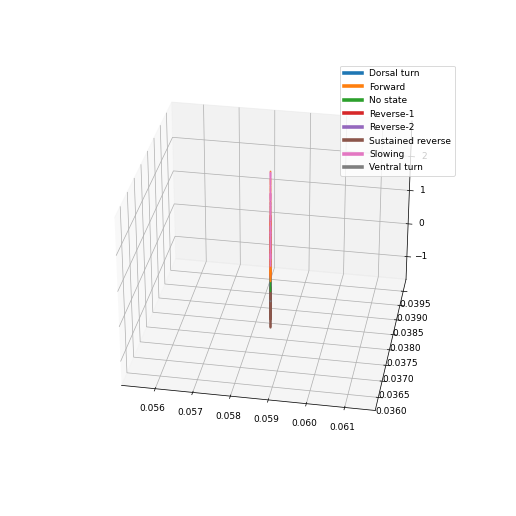

In [248]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

points = np.array(Y_train.T).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colors = [*mcolors.TABLEAU_COLORS.keys()][:8] ###
#cmap = cm.get_cmap('Pastel1')
#colors = cmap(np.arange(8))
for segment, state in zip(segments, B_train_1[:-1]):
    p = ax.plot3D(segment.T[0], segment.T[1], segment.T[2], color=colors[state] )
# Create legend
state_names = ['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']
legend_elements = [Line2D([0], [0], color=c, lw=4, label=state) for c, state in zip(colors, state_names)]
ax.legend(handles=legend_elements)
plt.show()

def rotate(angle):
    ax.view_init(azim=angle)
rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362, 5), interval=150)
rot_animation.save('rotation.gif', dpi=80, writer='imagemagick')


### Performing PCA on the latent dimension


(0.0, 2686.0, -0.5, 0.5)

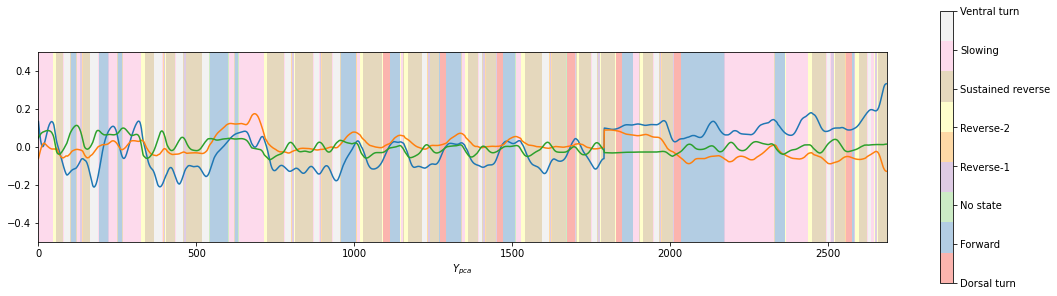

In [14]:
%matplotlib inline
pca = PCA()
Y_pca = pca.fit_transform(Y_train)
plt.figure(figsize=(19,5))
plt.imshow([B],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y_pca/Y_pca.max()/3)
plt.xlabel("time $t$")
plt.xlabel("$Y_{pca}$")
plt.axis([0,Y_pca.shape[0],-0.5,0.5])


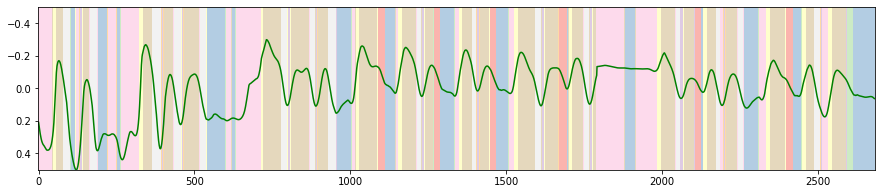

In [15]:
%matplotlib inline
pca = PCA()
Y_pca = pca.fit_transform(Y_train)
plt.figure(figsize=(15,3))
plt.imshow([B_train_1],aspect="auto",cmap="Pastel1")
#plt.plot(Y_pca[:,0]/2/np.max(np.abs(Y_pca[:,0])))
#plt.plot(Y_pca[:,1]/2/np.max(np.abs(Y_pca[:,1])), color='orange')
plt.plot(Y_pca[:,2]/2/np.max(np.abs(Y_pca[:,2])), color = 'green')

In [16]:
B_pred = model(X_train)[2].numpy().argmax(axis=1)
print("train accuracy of behaviour prediction: ", accuracy_score(B_pred, B_train_1))

NameError: name 'model' is not defined

In [ ]:
B_pred = model(X_test)[2].numpy().argmax(axis=1)
print("test accuracy of behaviour prediction: ", accuracy_score(B_pred, B_test_1))